# <center>PERSONAL TASK</center>
#### prepared by Artur Markov 

## AGENDA:
### GET ALL PHONE MODELS DATASET FROM gsmarena.com
### TODO:
- scrap data from gsmarena.com
- postprocess data
- fill nan values for field is_tablet

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kstest
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [2]:

def strip_vendor(vendor: str, model: str) -> str:
    splitted = model.split(' ')
    if splitted[0] == vendor:
        return ' '.join(splitted[1:])
    return model

def postprocess_iphone(vendor: str, main_model: str, model: str) -> str:
    if vendor=='apple' and main_model !=model:
        if '.' in model:
            model = model.replace('.', ',')
    
    return model

def show_not_null_percent(dataframe: pd.DataFrame) -> pd.DataFrame:
    return (1 - pd.DataFrame((dataframe.isna().sum() / dataframe.shape[0]))).T

_float_regex_ ='[0-9][0-9][.][0-9][0-9]|[0-9][.][0-9][0-9]|[0-9]|[0-9][.]|[0-9][.][0-9]'

In [3]:
gsmarena_data = pd.read_csv('data/concated_full_raw.csv', low_memory=False)

In [4]:
print('gsmarena_data', gsmarena_data.shape)

gsmarena_data (11215, 72)


### GsmArena Preprocess

### Row data analysis

In [5]:
show_not_null_percent(gsmarena_data)

,brand,scrapped_from,updated_at,keywords,description,nettech,net2g,gprstext,edge,year,status,dimensions,weight,sim,displaytype,displaysize,displayresolution,os,chipset,cpu,gpu,memoryslot,internalmemory,cam1modules,cam1video,cam2modules,cam2video,wlan,bluetooth,gps,nfc,radio,usb,sensors,featuresother,batdescription1,colors,price,displaysize-hl,displayres-hl,camerapixels-hl,videopixels-hl,ramsize-hl,chipset-hl,batsize-hl,battype-hl,released-hl,body-hl,os-hl,storage-hl,net3g,net4g,speed,displayprotection,cam1features,cam2features,optionalother,batstandby1,battalktime1,tbench,batlife,comment,bodyother,models,modelname,sar-eu,batmusicplayback1,displayother,sar-us,memoryother,build,net5g
0,1.0,1.0,1.0,0.987428,0.987428,0.999822,0.999822,0.364868,0.365493,0.998573,0.999822,0.997949,0.991708,0.999733,0.999465,0.892287,0.995631,0.664913,0.544984,0.65457,0.535444,0.999822,0.842354,0.999465,0.878645,0.882033,0.23317,0.999554,0.999643,0.997236,0.571378,0.994026,0.919929,0.634418,0.521623,0.999198,0.944984,0.649755,0.999822,0.995631,0.885956,0.976906,0.635845,0.544984,0.952831,0.995631,0.999822,0.974677,0.999822,0.999822,0.658939,0.357735,0.660633,0.204904,0.580205,0.162193,0.097013,0.605082,0.637093,0.064111,0.076505,0.33794,0.149621,0.271333,0.038431,0.240392,0.065448,0.260633,0.215872,0.011681,0.153009,0.046099


See problem with modelname. But we ban receive it from keywords column, but for more data let`s join woth old data

In [6]:
old_models_row = pd.read_csv('data/concated_full_old.csv')

In [7]:
show_not_null_percent(old_models_row)

,brand,scrapped_from,updated_at,modelname,os-hl,cpu,gpu,displayresolution,displaytype,models,memoryother
0,1.0,1.0,1.0,0.997746,1.0,0.653083,0.533087,0.995853,0.999639,0.265326,0.293996


In [8]:
gsmarena_data = gsmarena_data.merge(
            old_models_row[['scrapped_from', 'modelname', 'models']],
            how='left', on='scrapped_from', suffixes=['', '_old'])

All columns in the dataset
Legend of the columns can be seen https://www.gsmarena.com/samsung_galaxy_z_fold4-11737.php


In [9]:
gsmarena_data.columns

Index(['brand', 'scrapped_from', 'updated_at', 'keywords', 'description',
       'nettech', 'net2g', 'gprstext', 'edge', 'year', 'status', 'dimensions',
       'weight', 'sim', 'displaytype', 'displaysize', 'displayresolution',
       'os', 'chipset', 'cpu', 'gpu', 'memoryslot', 'internalmemory',
       'cam1modules', 'cam1video', 'cam2modules', 'cam2video', 'wlan',
       'bluetooth', 'gps', 'nfc', 'radio', 'usb', 'sensors', 'featuresother',
       'batdescription1', 'colors', 'price', 'displaysize-hl', 'displayres-hl',
       'camerapixels-hl', 'videopixels-hl', 'ramsize-hl', 'chipset-hl',
       'batsize-hl', 'battype-hl', 'released-hl', 'body-hl', 'os-hl',
       'storage-hl', 'net3g', 'net4g', 'speed', 'displayprotection',
       'cam1features', 'cam2features', 'optionalother', 'batstandby1',
       'battalktime1', 'tbench', 'batlife', 'comment', 'bodyother', 'models',
       'modelname', 'sar-eu', 'batmusicplayback1', 'displayother', 'sar-us',
       'memoryother', 'build', 'net5

### Data preprocess

In [10]:
# preprocess keywords

infoo = pd.DataFrame(
    (gsmarena_data.keywords
        .fillna('')
        .str.replace(',cellphone,information,info,specs,specification,opinion,review', '')
        .str.split(',')
    ).tolist(),
    index=gsmarena_data.index)

infoo.columns = ['modelname', 'brand', 'main_model', 'net', 'type', 'device_type']
infoo.drop(columns=['type', 'net'], inplace=True)
infoo = infoo.add_suffix('_frm_kw')

gsmarena_data = pd.concat([gsmarena_data, infoo], axis=1)

gsmarena_data.models.fillna(gsmarena_data.models_old, inplace=True)

gsmarena_data.loc[gsmarena_data.modelname_frm_kw=='', 'modelname_frm_kw'] = None

gsmarena_data.modelname_frm_kw.fillna(gsmarena_data.modelname_old, inplace=True)

gsmarena_data.modelname_frm_kw.fillna(gsmarena_data.modelname, inplace=True)

gsmarena_data.drop(columns=['modelname'], inplace=True)

gsmarena_data.rename(
    columns={
        'modelname_frm_kw':'modelname',
        'main_model_frm_kw':'main_model',
        'device_type_frm_kw':'device_type'
    }, inplace=True)


gsmarena_data.loc[gsmarena_data.modelname.isna(), 'modelname'] = gsmarena_data[gsmarena_data.modelname.isna()].scrapped_from.str.split('-').apply(lambda x: x[0]).str.replace('_', ' ')

gsmarena_data.modelname = gsmarena_data.modelname.str.lower()
gsmarena_data.main_model = gsmarena_data.main_model.str.lower()
gsmarena_data.models = gsmarena_data.models.str.lower()

gsmarena_data.loc[gsmarena_data.main_model.isna(), 'main_model'] = gsmarena_data[gsmarena_data.main_model.isna()].apply(lambda row: strip_vendor(str(row['brand']), str(row['modelname'])), axis=1)

In [11]:
# all model names
gsmarena_data['all_models'] = gsmarena_data.main_model + ', ' + gsmarena_data.models.fillna('')
gsmarena_data['all_models'] = gsmarena_data.all_models.apply(lambda row: row.split(', '))

In [12]:
df = gsmarena_data[[
    'scrapped_from', 'brand', 'device_type', 'main_model', 'year', 'dimensions', 'weight', 'displaytype', 'displaysize', 'displayresolution', 'os-hl', 'body-hl', 'displaysize-hl', 'displayres-hl',
    'price'
]]

In [13]:
df.loc[df.main_model.str.lower().str.contains('watch'), 'device_type'] = 'watch'

#### displayresolution preprocess


In [14]:
df['ppi'] = df.displayresolution.fillna('').str.extract('[~](\d\d\d\d|\d\d\d|\d\d|\d)').astype(float)
df['ratio'] = df.displayresolution.fillna('').str.extract('(\d\d[:]\d\d|\d\d[:]\d|\d[:]\d\d|\d[:]\d)')
df[['ratio_x', 'ratio_y']] = pd.DataFrame(df.ratio.str.split(':').fillna('00').apply(list).tolist(), index=df.index).replace('0', None).astype(float)

#### Screen features preprocess

In [15]:
df['diagonal_inch'] = df.displaysize.str.extract('((?<=^).*(?=[ ][i][n][c][h][e][s]))').astype(float)
df['screen_to_body'] = df.displaysize.str.extract('((?<=[~]).*(?=[%]))').astype(float) * .01

#### Weights preprocess

In [16]:
df['weight_oz'] = (df.weight
    .str.extract('([0-9][0-9][0-9][0-9]|[0-9][0-9][0-9]|[0-9][0-9])[ ][g]')
    .astype(float) / 28.34952 ).round(2)

In [17]:
dims = df.dimensions.str.extract('((\d+[.]\d+|\d+)[ ][x][ ](\d+[.]\d+|\d+)[ ][x][ ](\d+[.]\d+|\d+))[ ][i][n]')
dims.columns=['dims', 'dim_x', 'dim_y', 'dim_z']
dims.dim_x = dims.dim_x.astype(float)
dims.dim_y = dims.dim_y.astype(float)
dims.dim_z = dims.dim_z.astype(float)

In [18]:
df = pd.concat([df, dims], axis=1)

In [19]:
df['pixels'] = df.displayresolution.fillna('').str.lower().str.extract(
    # '((?<=^).*(?=[ ][p][i][x][e][l][s]))'
    '(\d\d\d\d[ ][x][ ]\d\d\d\d|\d\d\d[ ][x][ ]\d\d\d\d|\d\d\d\d[ ][x][ ]\d\d\d|\d\d\d[ ][x][ ]\d\d\d|\d\d\d[ ][x][ ]\d\d|\d\d[ ][x][ ]\d\d\d|\d\d[ ][x][ ]\d\d|\d\d[ ][x][ ]\d|\d[ ][x][ ]\d)[ ][p][i][x][e][l][s]'
)

df[['pixels_x', 'pixels_y']] = pd.DataFrame(df.pixels.fillna('0 x 0').str.split(' x ').tolist(), index=df.index).replace('0', None).astype(float)

#### OS type extraction

In [20]:
df['os_type'] = 'other'

df.loc[
    df['os-hl'].fillna('').str.lower().str.contains('android'),
    'os_type'
] = 'android'

df.loc[
    (df['os-hl'].fillna('').str.lower().str.contains('ios')) 
        & (~df['os-hl'].fillna('').str.lower().str.contains('android'))
        & (~df['os-hl'].fillna('').str.lower().str.contains('kaios')) ,
    'os_type'
] = 'ios'
df.loc[df['os-hl'].fillna('').str.contains('iPadOS'), 'os_type'] = 'ios'

df.loc[df['os-hl'].fillna('').str.contains('watchOS'), 'os_type'] = 'watchOS'

df.loc[df['os-hl'].fillna('').str.lower().str.contains('microsoft'), 'os_type'] = 'microsoft'
df.loc[df['os-hl'].fillna('').str.lower().str.contains('windows'), 'os_type'] = 'microsoft'

df.loc[df['os-hl'].fillna('').str.contains('Chrome OS'), 'os_type'] = 'chromeOS'

In [21]:
df.os_type.value_counts()

android      6366
other        4247
microsoft     503
ios            69
watchOS        29
chromeOS        1
Name: os_type, dtype: int64

#### Os version extract

In [22]:
df['os_version'] = df['os-hl'].str.extract(
    '([0-9][0-9][.][0-9][0-9]|[0-9][0-9][.][0-9]|[0-9][.][0-9]|[0-9][.][0-9][0-9]|[0-9][0-9]|[0-9])'
).astype(float)

In [23]:
tt = df['os-hl'].str.extractall(
    '([0-9][0-9][.][0-9][0-9]|[0-9][0-9][.][0-9]|[0-9][.][0-9]|[0-9][.][0-9][0-9]|[0-9][0-9]|[0-9])'
).reset_index()

tt['max_value'] = tt.groupby(['level_0'])[0].max()
tt[0] = tt[0].astype(float)

df['os_version_max'] = tt.groupby(['level_0'])[0].max()
df.os_version = df.os_version.astype(float)

In [24]:
df.os_version = df[['os_version', 'os_version_max']].max(axis=1)
df.drop(columns=['os_version_max'], inplace=True)

In [25]:
df.columns

Index(['scrapped_from', 'brand', 'device_type', 'main_model', 'year',
       'dimensions', 'weight', 'displaytype', 'displaysize',
       'displayresolution', 'os-hl', 'body-hl', 'displaysize-hl',
       'displayres-hl', 'price', 'ppi', 'ratio', 'ratio_x', 'ratio_y',
       'diagonal_inch', 'screen_to_body', 'weight_oz', 'dims', 'dim_x',
       'dim_y', 'dim_z', 'pixels', 'pixels_x', 'pixels_y', 'os_type',
       'os_version'],
      dtype='object')

#### Extract prices

In [26]:
prices = df.price.str.replace('\u2009', '').str.extract('((\d+[.]\d+|\d+)[ ][E][U][R]|[€](\d[,]\d+[.]\d+)|[€](\d+[.]\d+))')
prices.columns = ['eur', 'p1', 'p2', 'p3']
prices.p1.fillna(prices.p2, inplace=True)
prices.p1.fillna(prices.p3, inplace=True)

df['price_in_eur'] = prices.p1.str.replace(',','')
prices_usd = df.price.str.replace('\u2009', '').str.extract('((\d+[.]\d+|\d+)[ ][U][S][D]|[$](\d[,]\d+[.]\d+)|[$](\d+[.]\d+))')
prices_usd.columns = ['usd', 'p1', 'p2', 'p3']
prices_usd.p1.fillna(prices_usd.p2, inplace=True)
prices_usd.p1.fillna(prices_usd.p3, inplace=True)

df.loc[df.price_in_eur.isna(), 'price_in_eur'] = prices_usd.p1.str.replace(',','').astype(float) * 1.12 # yearly average

In [27]:
df_final = df[[
    'scrapped_from', 'brand', 'os_type','os_version' ,'device_type', 'main_model', 'displaytype',
    'diagonal_inch', 'screen_to_body', 'weight_oz', 'pixels_x', 'pixels_y', 'dim_x', 'dim_y', 'dim_z', 'ratio_x', 'ratio_y', 'ppi'
]]

### NaN analysis and validation

In [28]:
show_not_null_percent(df_final)

,scrapped_from,brand,os_type,os_version,device_type,main_model,displaytype,diagonal_inch,screen_to_body,weight_oz,pixels_x,pixels_y,dim_x,dim_y,dim_z,ratio_x,ratio_y,ppi
0,1.0,1.0,1.0,0.643602,0.987606,1.0,0.999465,0.890682,0.846812,0.812483,1.0,1.0,0.961213,0.961213,0.961213,1.0,1.0,0.883727


In [29]:
df_final.device_type.value_counts()

phone     10263
tablet      699
watch       114
Name: device_type, dtype: int64

In [30]:
df_final[df_final.os_version.isna()].os_type.value_counts()

other        3942
android        38
microsoft      16
chromeOS        1
Name: os_type, dtype: int64

### Loc only actual models for most android apps

In [31]:

actual_models = df_final[
    (df_final.device_type !='watch') &
    (
        ((df_final.os_type=='ios') & (df_final.os_version>=10))
        | ((df_final.os_type=='android') & (df_final.os_version>=4.4))
    )
]

In [32]:
show_not_null_percent(actual_models)

,scrapped_from,brand,os_type,os_version,device_type,main_model,displaytype,diagonal_inch,screen_to_body,weight_oz,pixels_x,pixels_y,dim_x,dim_y,dim_z,ratio_x,ratio_y,ppi
0,1.0,1.0,1.0,1.0,0.970888,1.0,1.0,0.999363,0.971738,0.821717,1.0,1.0,0.960051,0.960051,0.960051,1.0,1.0,0.998513


In [33]:
actual_models[actual_models.device_type.isna()].shape

(137, 18)

In [34]:
show_not_null_percent(actual_models[actual_models.device_type.isna()])

,scrapped_from,brand,os_type,os_version,device_type,main_model,displaytype,diagonal_inch,screen_to_body,weight_oz,pixels_x,pixels_y,dim_x,dim_y,dim_z,ratio_x,ratio_y,ppi
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.656934,1.0,1.0,0.963504,0.963504,0.963504,1.0,1.0,1.0


In [35]:
actual_models.loc[actual_models.diagonal_inch.isna(), 'diagonal_inch'] = np.sqrt(
    actual_models.screen_to_body.median() * (actual_models.dim_x**2 + actual_models.dim_y**2)
)

In [36]:
show_not_null_percent(actual_models[actual_models.screen_to_body.isna()])

,scrapped_from,brand,os_type,os_version,device_type,main_model,displaytype,diagonal_inch,screen_to_body,weight_oz,pixels_x,pixels_y,dim_x,dim_y,dim_z,ratio_x,ratio_y,ppi
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.18797,1.0,1.0,0.022556,0.022556,0.022556,1.0,1.0,0.969925


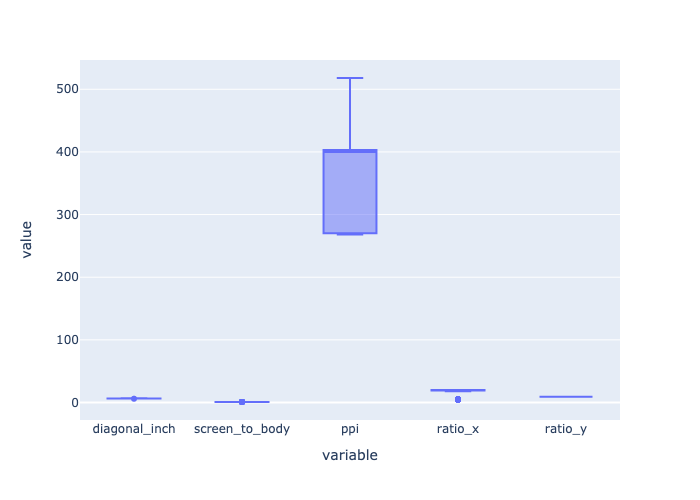

In [37]:
px.box(
    actual_models[actual_models.device_type.isna()][['diagonal_inch', 'screen_to_body', 'ppi', 'ratio_x', 'ratio_y']]
    ).show('png')

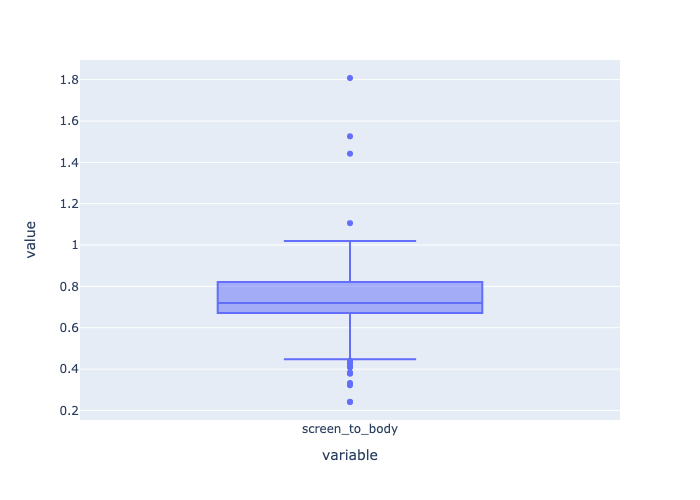

In [38]:
px.box(actual_models.screen_to_body).show('png')

In [39]:
actual_models['dummy_device_type'] = None
actual_models.loc[actual_models.device_type=='phone', 'dummy_device_type'] = 1
actual_models.loc[actual_models.device_type=='tablet', 'dummy_device_type'] = -1
actual_models.dummy_device_type = actual_models.dummy_device_type.astype(float)

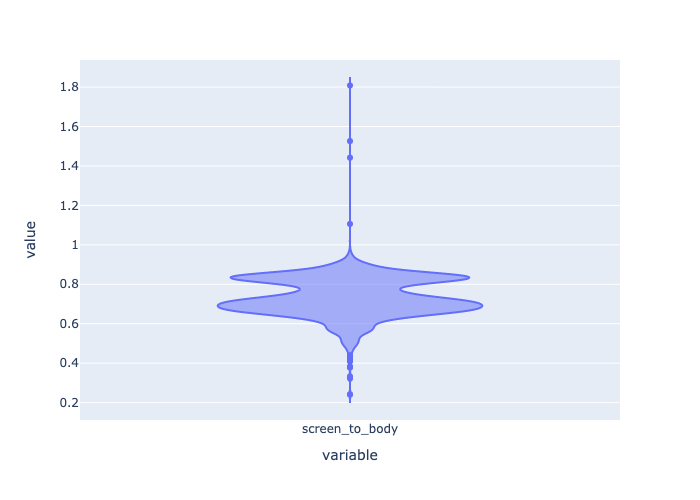

In [40]:
px.violin(actual_models.screen_to_body).show('png')

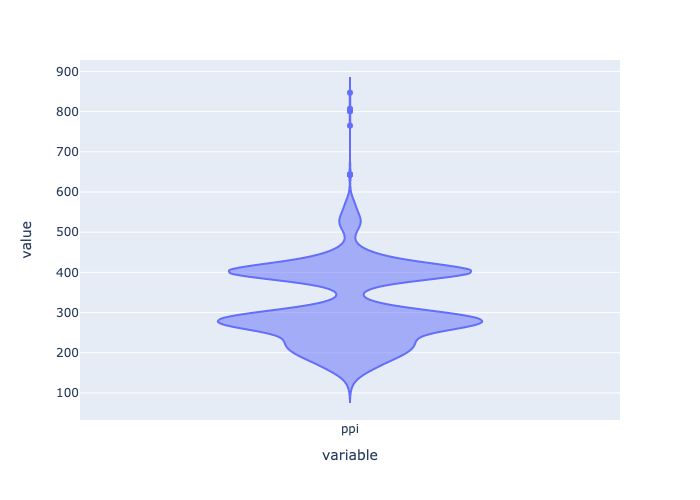

In [41]:
px.violin(actual_models.ppi).show('png')

In [42]:
actual_models.loc[actual_models.screen_to_body.isna(), 'screen_to_body'] = actual_models.screen_to_body.median()
actual_models.loc[actual_models.ppi.isna(), 'ppi'] = actual_models.ppi.mean()

In [43]:
train_df = actual_models[
    (actual_models.screen_to_body.between(0.457, .99))
][['scrapped_from', 'brand', 'os_type', 'os_version','device_type', 'dummy_device_type',
       'main_model', 'displaytype', 'diagonal_inch', 'screen_to_body',
       'weight_oz', 'pixels_x', 'pixels_y', 'dim_x', 'dim_y', 'dim_z',
       'ratio_x', 'ratio_y', 'ppi']]

In [44]:
train_df.device_type.fillna('unknown', inplace=True)

### DCA

In [45]:
def scatter_matrix(df, color: str="device_type"):
    df_v = df.copy()
    fig = px.scatter_matrix(df_v,
                            dimensions = df.columns.values,
                            color = color,
                            # mapbox_style = "stamen-watercolor",
                            # color_discrete_map = dict(red= 1, blue=0),
                            title = "Scatter plot", width=1400, height=1000)
    fig.update_traces(diagonal_visible=False)
    return fig

In [46]:
show_not_null_percent(train_df[['scrapped_from', 'dummy_device_type', 'diagonal_inch', 'screen_to_body',
       'pixels_x', 'pixels_y',# 'dim_x', 'dim_y', 'dim_z',
       'ratio_x', 'ratio_y', 'ppi']])

,scrapped_from,dummy_device_type,diagonal_inch,screen_to_body,pixels_x,pixels_y,ratio_x,ratio_y,ppi
0,1.0,0.970758,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [47]:
train_df[['dummy_device_type', 'diagonal_inch', 'screen_to_body',
       'pixels_x', 'pixels_y',# 'dim_x', 'dim_y', 'dim_z',
       'ratio_x', 'ratio_y', 'ppi']].corr()

,dummy_device_type,diagonal_inch,screen_to_body,pixels_x,pixels_y,ratio_x,ratio_y,ppi
dummy_device_type,1.000000,-0.706309,0.053627,-0.308020,0.021628,0.056458,-0.007024,0.291958
diagonal_inch,-0.706309,1.000000,0.531401,0.605352,0.463611,0.123105,0.286326,0.063445
screen_to_body,0.053627,0.531401,1.000000,0.499892,0.761978,0.219706,0.421665,0.507132
pixels_x,-0.308020,0.605352,0.499892,1.000000,0.792310,0.080726,0.281112,0.713184
pixels_y,0.021628,0.463611,0.761978,0.792310,1.000000,0.144466,0.353738,0.877880
ratio_x,0.056458,0.123105,0.219706,0.080726,0.144466,1.000000,0.628012,0.116358
ratio_y,-0.007024,0.286326,0.421665,0.281112,0.353738,0.628012,1.000000,0.287674
ppi,0.291958,0.063445,0.507132,0.713184,0.877880,0.116358,0.287674,1.000000


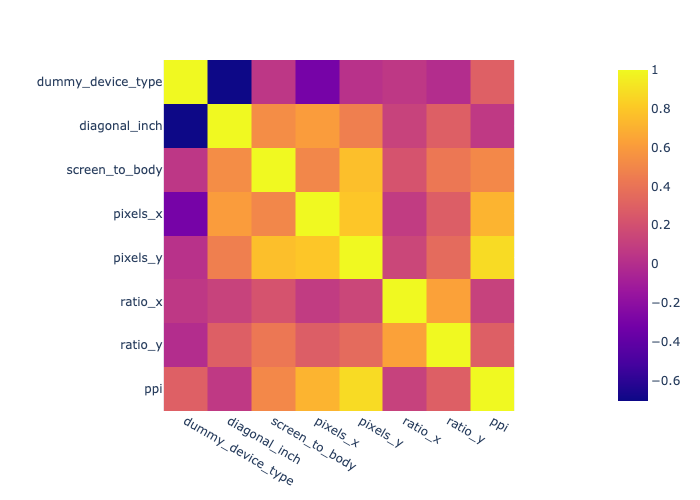

In [48]:
px.imshow(train_df[['dummy_device_type', 'diagonal_inch', 'screen_to_body',
       'pixels_x', 'pixels_y',# 'dim_x', 'dim_y', 'dim_z',
       'ratio_x', 'ratio_y', 'ppi']].corr()).show('png')

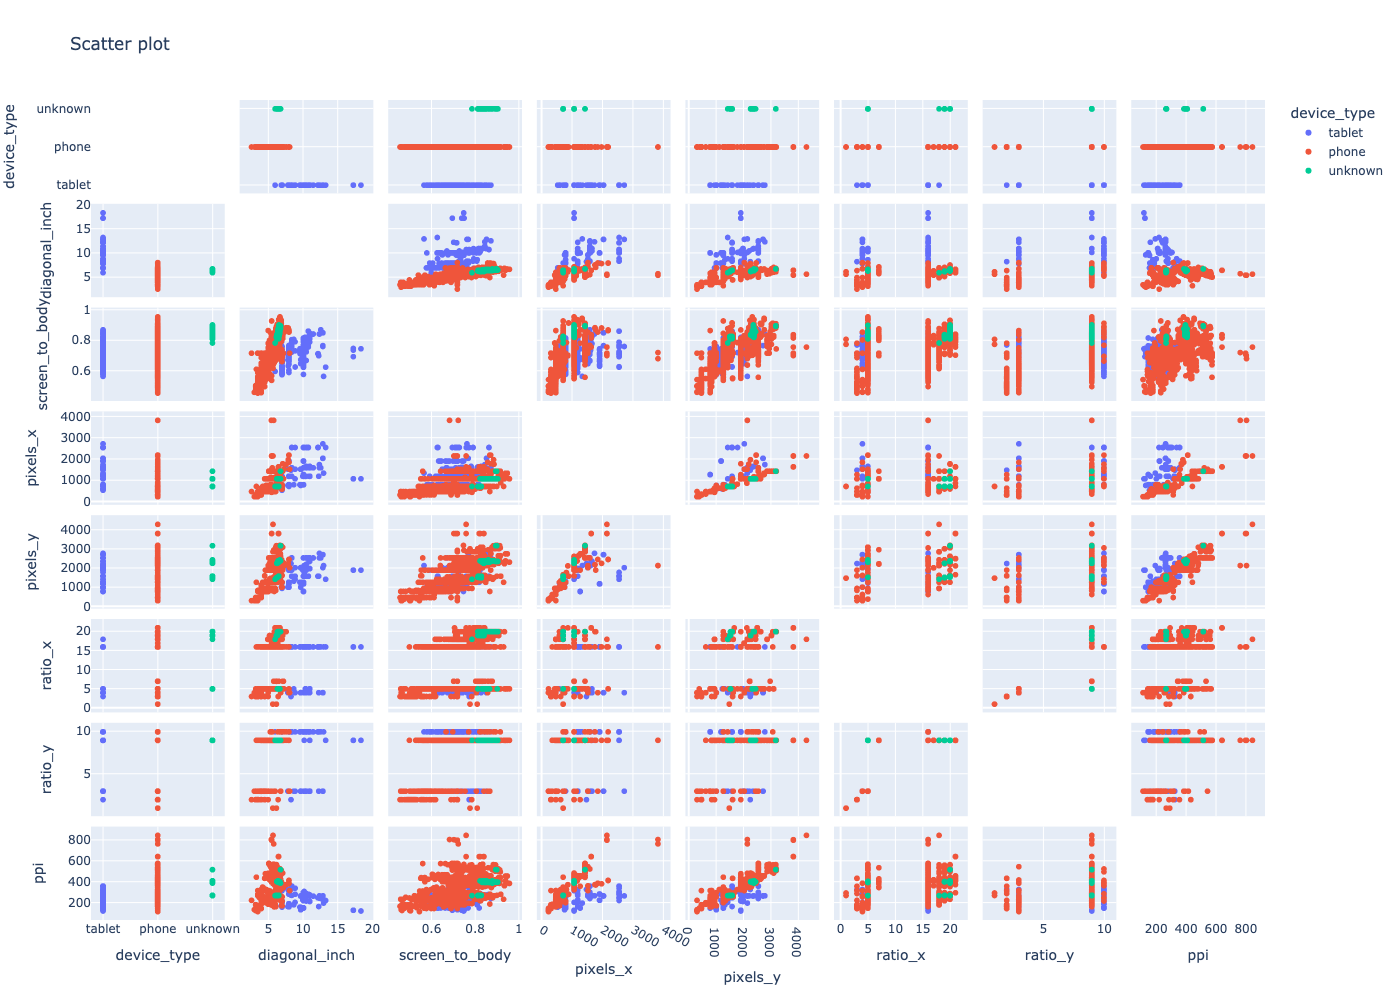

In [49]:
scatter_matrix(train_df[['device_type', 'diagonal_inch', 'screen_to_body',
       'pixels_x', 'pixels_y',# 'dim_x', 'dim_y', 'dim_z',
       'ratio_x', 'ratio_y', 'ppi']]).show('png')

In [50]:

fig = px.scatter(train_df, x='screen_to_body', y='diagonal_inch', color='device_type', marginal_x='violin', marginal_y='box',title='Diagonal to scren_to_body')

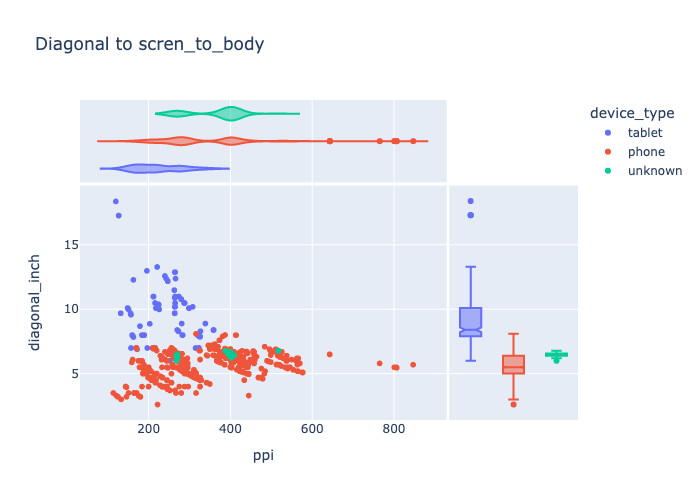

In [51]:
fig = px.scatter(train_df, x='ppi', y='diagonal_inch', color='device_type', marginal_x='violin', marginal_y='box',title='Diagonal to scren_to_body')
fig.show('png')

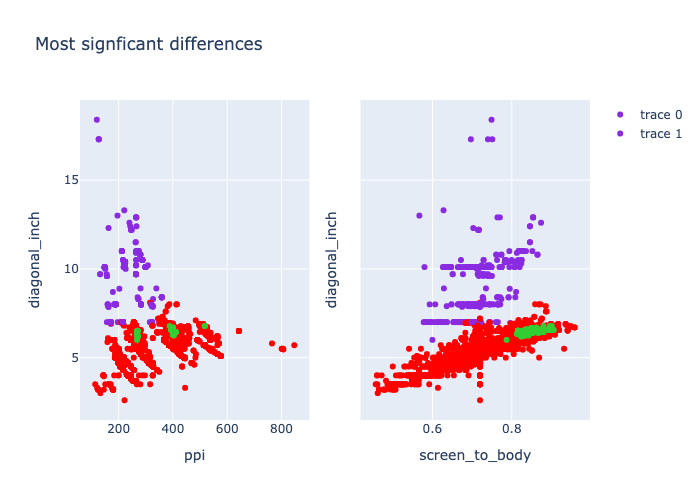

In [52]:
colors = {'tablet': 'blueviolet', 'phone':'red', 'unknown':'limegreen'}
fig = make_subplots(rows=1, cols=2, shared_xaxes=False, shared_yaxes=True)
fig.add_trace(go.Scatter(x=train_df.ppi, y=train_df['diagonal_inch'], mode='markers', marker=dict(color=train_df.device_type.apply(lambda x: colors[x]))), row=1, col=1)
fig.add_trace(go.Scatter(x=train_df['screen_to_body'], y=train_df['diagonal_inch'],mode='markers', marker=dict(color=train_df.device_type.apply(lambda x: colors[x]))), row=1, col=2)
fig.update_layout(title="Most signficant differences")
fig.update_xaxes(title='ppi', col=1, row=1)
fig.update_xaxes(title='screen_to_body', col=2, row=1)
fig.update_yaxes(title='diagonal_inch', col=1, row=1)
fig.update_yaxes(title='diagonal_inch', col=2, row=1)
fig.show('png')

### Data standartization

In [53]:
from sklearn.preprocessing import StandardScaler

In [54]:
data = train_df.copy()

In [55]:
data['dummy_device_type'] = None
data.loc[data.device_type=='phone', 'dummy_device_type'] = 1
data.loc[data.device_type=='tablet', 'dummy_device_type'] = -1

data.dummy_device_type = data.dummy_device_type.astype(float)

In [56]:
Sc = StandardScaler()

In [57]:
data[['diagonal_inch', 'screen_to_body', 'pixels_x', 'pixels_y', 'ratio_x', 'ratio_y', 'ppi']] = pd.DataFrame(
    Sc.fit_transform(data[['diagonal_inch', 'screen_to_body', 'pixels_x', 'pixels_y', 'ratio_x', 'ratio_y', 'ppi']]), 
    index=data.index
)


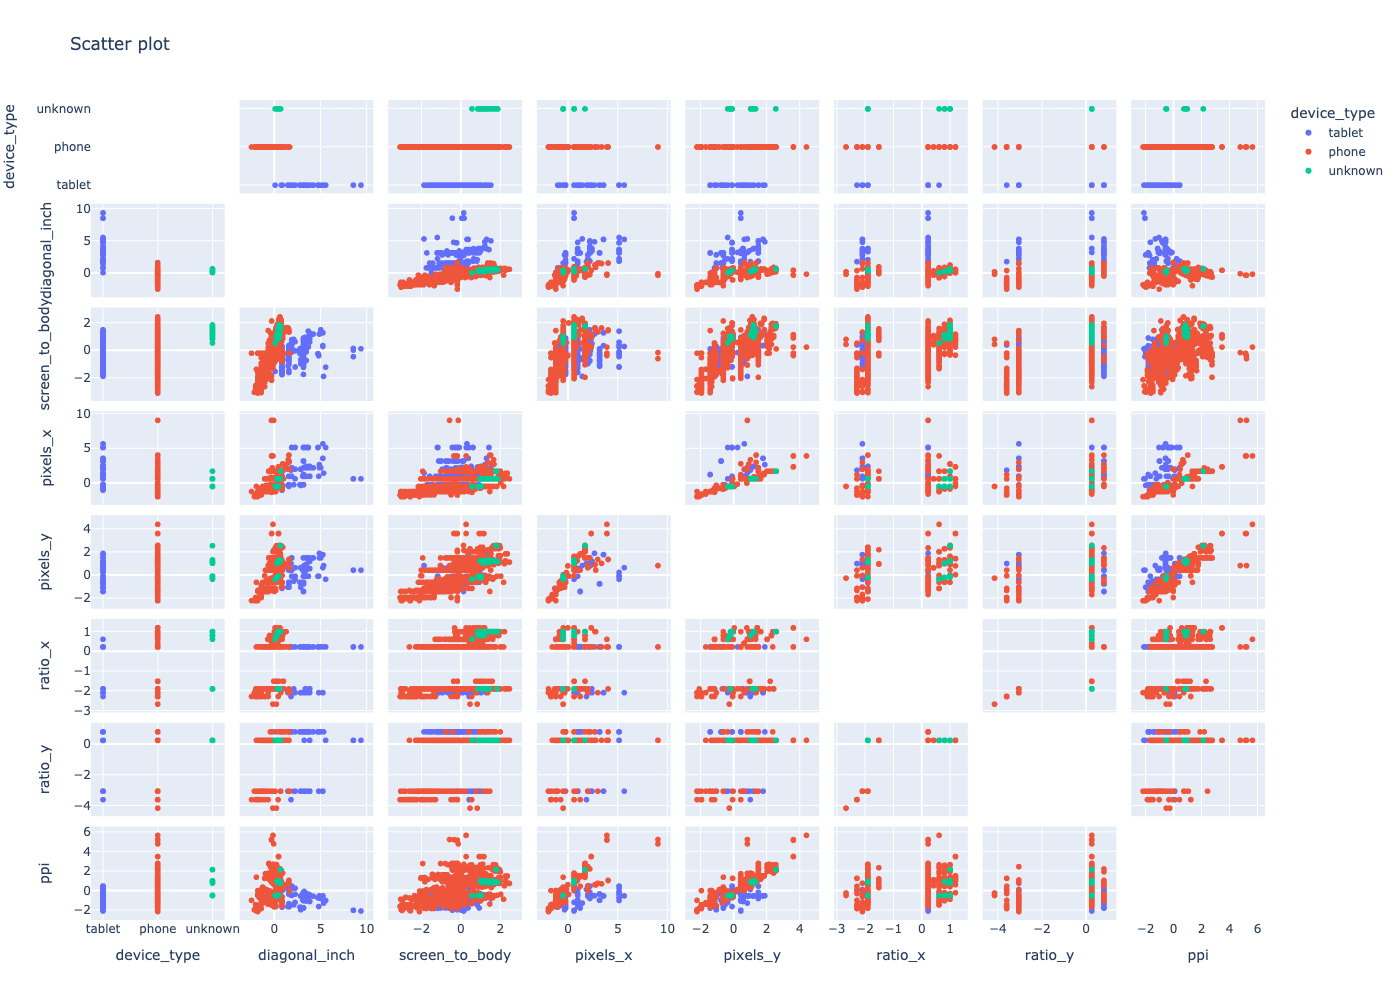

In [58]:
scatter_matrix(
    data[['device_type', 'diagonal_inch', 'screen_to_body', 'pixels_x', 'pixels_y', 'ratio_x', 'ratio_y', 'ppi']]
).show('png')

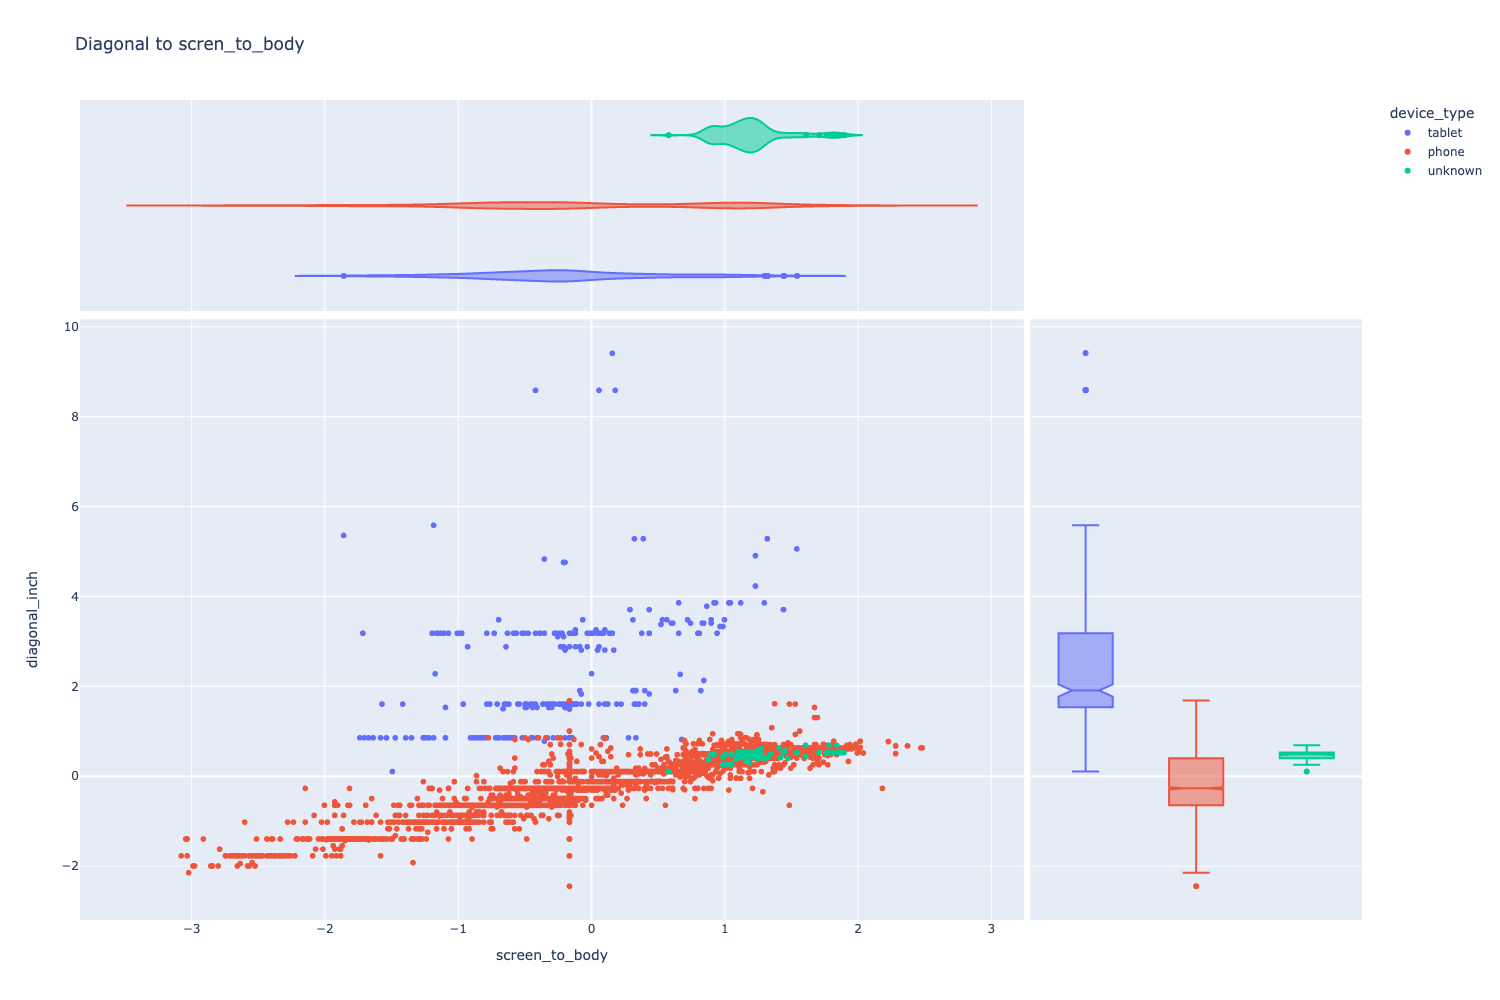

In [59]:

fig = px.scatter(data, x='screen_to_body', y='diagonal_inch', color='device_type', marginal_x='violin', marginal_y='box',title='Diagonal to scren_to_body', height=1000, width=1500)
fig.show('png')

In [60]:
cols = ['diagonal_inch', 'screen_to_body', 'pixels_x', 'pixels_y', 'ratio_x', 'ratio_y', 'ppi']

### ML

In [61]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [62]:
X_train_row, X_test_row, Y_train_row, Y_test_row = train_test_split(
    data[~data.dummy_device_type.isna()][['diagonal_inch', 'screen_to_body', 'ppi']],
    data[~data.dummy_device_type.isna()][['dummy_device_type']],
    test_size = 0.5, random_state =10
)

#### SVC

In [63]:
svc = SVC()
svc.fit(X_train_row, Y_train_row)
print(classification_report(svc.predict(X_test_row), Y_test_row))

              precision    recall  f1-score   support

        -1.0       0.98      0.95      0.96       181
         1.0       1.00      1.00      1.00      2093

    accuracy                           0.99      2274
   macro avg       0.99      0.97      0.98      2274
weighted avg       0.99      0.99      0.99      2274



## Results

In [64]:
vals = {1: 'phone', -1: 'tablet'}

In [65]:
results = data[['scrapped_from','device_type', 'dummy_device_type']]

In [66]:
results['fitted_device_type'] = svc.predict(data[['diagonal_inch', 'screen_to_body', 'ppi']])

In [67]:
results.fitted_device_type = results.fitted_device_type.apply(lambda x: vals[x])

In [68]:
results.device_type.fillna(results.fitted_device_type, inplace=True)

In [69]:
ans = (gsmarena_data[['scrapped_from', 'updated_at', 'all_models']]
    .merge(df[['scrapped_from', 'brand', 'device_type', 'main_model', 'year', 'os_type', 'os_version', 'diagonal_inch', 'ppi', 'ratio', 'price_in_eur']], how='inner', on='scrapped_from')
    .merge(results[['scrapped_from', 'device_type']], how='left',on='scrapped_from', suffixes=['','_fitted'])
)


In [70]:
ans.device_type.fillna(ans.device_type_fitted, inplace=True)
ans.drop(columns='device_type_fitted', inplace=True)

In [71]:
show_not_null_percent(ans)

,scrapped_from,updated_at,all_models,brand,device_type,main_model,year,os_type,os_version,diagonal_inch,ppi,ratio,price_in_eur
0,1.0,1.0,1.0,1.0,0.999822,1.0,0.998573,1.0,0.643602,0.890682,0.883727,0.800713,0.631654


#### Explode dataset for all possible models

In [72]:
gsmarena_data_exploded = ans.explode('all_models')
gsmarena_data_exploded = gsmarena_data_exploded[gsmarena_data_exploded.all_models != '']
gsmarena_data_exploded.rename(columns={'brand': 'vendor', 'all_models': 'model'}, inplace=True)

# DATA POSTPROCESS
gsmarena_data_exploded['model'] = gsmarena_data_exploded.apply(lambda row: postprocess_iphone(row['vendor'], row['main_model'], row['model']), axis=1)

# DROP ALL WATCHES
gsmarena_data_exploded = gsmarena_data_exploded[~gsmarena_data_exploded.model.str.contains('watch', regex=False)]
gsmarena_data_exploded = gsmarena_data_exploded[~gsmarena_data_exploded.main_model.str.contains('watch', regex=False)]

In [73]:
show_not_null_percent(gsmarena_data_exploded)

,scrapped_from,updated_at,model,vendor,device_type,main_model,year,os_type,os_version,diagonal_inch,ppi,ratio,price_in_eur
0,1.0,1.0,1.0,1.0,0.999837,1.0,0.999078,1.0,0.778826,0.933539,0.929148,0.863338,0.748414
